In [5]:
import pandas as pd
import numpy as np
import pyannote.audio
import librosa
import matplotlib.pyplot as plt
import librosa.display
import os
from pandas.api.types import CategoricalDtype


In [6]:
fname = '../data/raw/z-c-feisty.wav'
filename_base =os.path.splitext(os.path.basename(fname))[0]
x, sr = librosa.load(fname)
print(filename_base)
#!ffmpeg -i ../data/raw/z-c-feisty.wav ../data/processed/z-c-feisty.mp3 

z-c-feisty


In [4]:
fname_rttm = '../data/processed/test.rttm'
speaker_track = pd.read_csv(fname_rttm,header=None,delim_whitespace=True,
            names = ['x1','filename','fileid','start','duration','skip1','skip2','speaker_id','skip3'])
speaker_track['end'] = speaker_track['start']+speaker_track['duration']
bins_speaker = pd.DataFrame({'name':speaker_track['speaker_id'].values},index = pd.IntervalIndex.from_arrays(left = speaker_track['start'],right=speaker_track['end']))
speaker_track.drop(['skip1','skip2','skip3'],axis=1,inplace = True)
speaker_track.head(2)
cat_type = CategoricalDtype(categories=speaker_track['speaker_id'].unique().tolist())


In [8]:
#librosa.output.write_wav('../data/raw/z-c-feisty.mp3', x, sr)
df = pd.DataFrame({"time":np.arange(x.shape[0])/sr,"amplitude":x})


In [6]:
def find_speaker(x):
    try:
        res =bins_speaker.loc[x,'name'].values[0]
    except:
        res=np.nan
    return res
#t = tmp.reset_index()
tmp = df.sample(frac=0.005).sort_values('time')
speaker_id = tmp['time'].apply(lambda x: find_speaker(x))
speaker_id.head()
tmp['speaker']  =speaker_id.astype(cat_type)
tmp.set_index('time',inplace=True,drop=False)


 97%|█████████▋| 328/338 [02:01<00:03,  2.86it/s]


100%|██████████| 338/338 [02:05<00:00,  2.61it/s]

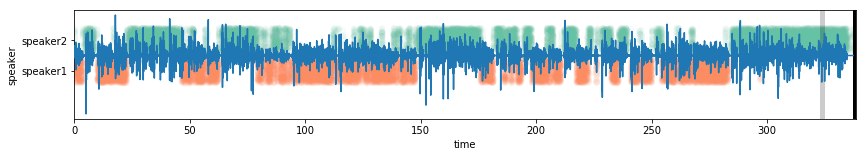

In [68]:
import seaborn as sns
from tqdm import trange
folder_output =os.path.abspath(os.path.splitext(fname)[0])
folder_output_ff =os.path.abspath(os.path.splitext(fname)[0])

os.makedirs(folder_output,exist_ok=True)
#fig,ax = plt.subplots(figsize=(27, 5),nrows=2,gridspec_kw = {'height_ratios':[3,2]})
fig,ax = plt.subplots(figsize=(14, 2),nrows=1)

tmp['speaker_cat'] = tmp['speaker'].cat.codes
tmp.loc[tmp['speaker_cat'] == -1,'speaker_cat'] = np.NaN
sns.stripplot(x='time',y='speaker',data= tmp,ax=ax,alpha=0.05,palette='Set2',jitter = 0.4,size=6.5,zorder=0)
tmp['amp_scaled'] = np.mean(ax.get_ylim())+tmp['amplitude']*len(tmp['speaker'].unique())

tmp['amp_scaled'].plot(ax=ax,zorder=10)
sec=0
dsec= 15
#line = ax[1].axvline(sec,c = 'k',linewidth=5)
line = ax.axvline(sec,c = 'k',linewidth=5)
line_l = ax.axvline(sec-dsec*0.95,c = 'k',alpha=0.2,linewidth=5)
line_r = ax.axvline(sec+dsec*0.95,c = 'k',alpha=0.2,linewidth=5)

n_frames = 337


sec_per_frame = (df['time'].max()+1) / n_frames
ax.set_xlim([0,df['time'].max()+1])

frame_rate = x.shape[0]/sr/(n_frames+1)
tmp_file_ffmpeg = ['ffconcat version 1.0\n']




for fr in trange(n_frames+1):
    sec = np.round(fr * sec_per_frame)
#    sub_tmp = tmp[(tmp.index>sec-dsec) & (tmp.index<sec+dsec)].copy()
#    sns.stripplot(x='time',y='speaker',data= sub_tmp,ax=ax[0],alpha=0.5,palette='Set2',jitter = 0.3,size=7.5,zorder=0)
 #   sub_tmp['amp_scaled'] = sub_tmp['speaker_cat']+sub_tmp['amplitude'] * sub_tmp['speaker_cat'].unique().shape[0]
 #   sub_tmp['amp_scaled'].plot(ax=ax[0],zorder=10)
    
  #  line_top_panel = ax[0].axvline(sec,c = 'k',linewidth=5)
    png_name = f'{np.int(fr):04d}.png'
    fig_name = os.path.join(folder_output,png_name)
    line.set_xdata([sec,sec])
    line_l.set_xdata(sec-dsec*0.95)
    line_r.set_xdata(sec+dsec*0.95)
 #   ax[0].set_xlabel('')
    fig.savefig(fig_name,dpi = 150)
    tmp_file_ffmpeg.append(f'file {png_name}\n')
    tmp_file_ffmpeg.append(f'duration {frame_rate}\n')
  #  ax[0].clear()

In [69]:
tmp_file_ffmpeg_fixed = tmp_file_ffmpeg
tmp_file_ffmpeg_fixed.append(f'file {png_name}\n')
ffstr = ''.join(tmp_file_ffmpeg_fixed)
with open(os.path.join(folder_output,f'{filename_base}.txt'),'w') as f:
    f.write(ffstr)

In [67]:
len(tmp_file_ffmpeg)
tmp_file_ffmpeg[-1]

'file 0337.png\n'

In [42]:
#ffmpeg -f concat -i input.txt -vsync vfr -pix_fmt yuv420p output.mp4
concat_file = os.path.join(folder_output,f'{filename_base}.txt')
cmd = f'ffmpeg -pix_fmt yuv420p -vsync vfr -i {concat_file} output.mp4'
print(cmd)

ffmpeg -pix_fmt yuv420p -vsync vfr -i D:\Repos\diurisation-pet-proj\data\raw\z-c-feisty\z-c-feisty.txt output.mp4


## Test Bokeh with callbacks for audio ( build a prototype )

In [25]:
from bokeh.plotting import figure, show
from bokeh.models.callbacks import CustomJS
from bokeh.models import ColorBar, LinearColorMapper, Div, HoverTool, ColumnDataSource, TapTool
from bokeh.io import save
from bokeh.layouts import row, column
from bokeh.palettes import RdBu11, OrRd9,Blues9
from bokeh.transform import linear_cmap
bokeh.io.reset_output()
bokeh.io.output_notebook()

df_small = df.sample(frac = 0.0005).sort_values('time')

Loading BokehJS ...

In [39]:
print(df_small.shape)
s1 = ColumnDataSource(df_small)
s2 = ColumnDataSource({'x':[150,150],'y':[-0.5,0.5]})
p = figure(plot_width=700, plot_height=150, title="Audio Waveform",
           toolbar_location='above', tools=[])
p.vbar(x='time',top='amplitude',source = s1,width = 1)
p.line(x='x',y='y',source = s2,line_width=2,color='black')

def callback_tap(s2=s2):
    xpos = cb_obj.x
    data = s2.data
    print(xpos)
    data['x']=[xpos,xpos]
    s2.change.emit()

p.js_on_event('tap',CustomJS.from_py_func(callback_tap))



show(p)


(3719, 2)


Error checking for conflicts.
Traceback (most recent call last):
  File "C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\pyBK\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2897, in _dep_map
    return self.__dep_map
  File "C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\pyBK\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2691, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\pyBK\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2888, in _parsed_pkg_info
    return self._pkg_info
  File "C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\pyBK\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2691, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of t